In [51]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import operator
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

## Challengue
It's time to revisit your classifier from the previous assignment. Using the evaluation techniques we've covered here, look at your classifier's performance in more detail. Then go back and iterate by engineering new features, removing poor features, or tuning parameters. Repeat this process until you have five different versions of your classifier. Once you've iterated, answer these questions to compare the performance of each:

Do any of your classifiers seem to overfit?
Which seem to perform the best? Why?
Which features seemed to be most impactful to performance?
Write up your iterations and answers to the above questions in a few pages. Submit a link below and go over it with your mentor to see if they have any other ideas on how you could improve your classifier's performance.

First let's create our original model

In [52]:
path = '/Users/Stephanie/desktop/thinkful/projects/3_bootcamp/' \
       'U2L2P7/sentiment labelled sentences/NAME_labelled.txt'

df = pd.DataFrame()
for company in ('yelp', 'imdb', 'amazon_cells'):
    company_df = pd.read_csv(path.replace('NAME', company), delimiter='\t', names=['Sentence', 'Sentiment'])
    company_df['Company'] = company
    print('{} length is {}'.format(company, len(company_df)))
    df = df.append(company_df)
    
df.Sentence = df.Sentence.str.lower()

yelp = df[df['Company'] == 'yelp'][['Sentence', 'Sentiment']]
amazon_cells = df[df['Company'] == 'amazon_cells'][['Sentence', 'Sentiment']]

yelp length is 1000
imdb length is 748
amazon_cells length is 1000


In [53]:
pos_kwords = ['amazing', 'best', 'friendly', 'nice', 'love', 'great']
neg_kwords = ["don't", 'ever', 'never', 'not', 'bad', 'again', 'no']

kwords = pos_kwords + neg_kwords

for key in kwords:
    yelp.Sentence = ' ' + yelp.Sentence.astype(str) + ' '
    yelp[str(key)] = yelp.Sentence.str.contains(
        ' ' + str(key) + ' ',
        case=False
    )

Let's see how many of the 1000 entries have any of the positive or negative keywords. We won't include the amplifiers as they increase the sentiment but work in combination with a negative or positive keyword

In [54]:
len(yelp[yelp.loc[:,'amazing':'no'].any(1)])

296

Let's check if we have a strong correlation between any of the keywords

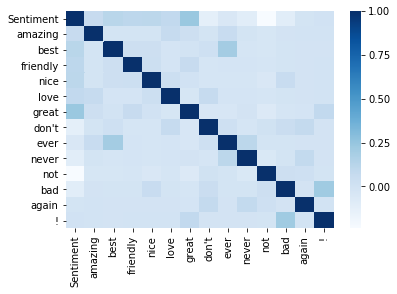

In [55]:
sns.heatmap(yelp.corr(), cmap="Blues")

It looks good.

### Predict against the same df (yelp)

In [56]:
data = yelp[kwords]
target = yelp['Sentiment']

bnb = BernoulliNB()
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

Number of mislabeled points out of a total 1000 points : 380


### Predict against another df (amazon)

In [57]:
for key in kwords:
    amazon_cells.Sentence = ' ' + amazon_cells.Sentence.astype(str) + ' '
    amazon_cells[str(key)] = amazon_cells.Sentence.str.contains(
        ' ' + str(key) + ' ',
        case=False
    )

data_amazon = amazon_cells[kwords]
target_amazon = amazon_cells['Sentiment']

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data_amazon)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data_amazon.shape[0],
    (target_amazon != y_pred).sum()
))

Number of mislabeled points out of a total 1000 points : 384


### Success rate

In [58]:
success = (target_amazon == y_pred).sum() / data_amazon.shape[0]
success

0.616

In [59]:
target_amazon_names = target_amazon.apply(lambda x: 'positive' if  x == 0 else 'negative')
y_pred_names = pd.Series(y_pred).apply(lambda x: 'positive' if  x == 0 else 'negative')

In [60]:
pd.crosstab(target_amazon_names, y_pred_names,
            rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,negative,positive,All
True,,,
negative,478,22,500
positive,362,138,500
All,840,160,1000


The model is over estimating negative reviews

### Cross validation

In [61]:
cross_val_score(bnb, data, target, cv=10)

array([0.66, 0.61, 0.56, 0.58, 0.6 , 0.62, 0.62, 0.63, 0.58, 0.6 ])

The model is not overfitting

### Improving the model

In [62]:
print(yelp.groupby('Sentiment').Sentence.apply(lambda x: x.str.count('!').mean()))
print(yelp.groupby('Sentiment').Sentence.apply(lambda x: x.str.count('!').std()))

Sentiment
0    0.152
1    0.350
Name: Sentence, dtype: float64
Sentiment
0    0.563499
1    1.235538
Name: Sentence, dtype: float64


In [63]:
yelp[['Sentence', 'Sentiment']][yelp.Sentence.apply(lambda x: x.count('!')) >0].groupby('Sentiment').count()

,Sentence
Sentiment,
0,55
1,111


Exclamation points are more common on negative reviews